**Интернет магазин занимается продажей компьютерных игр по вему Миру.
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.
Необходимо выявить закономерности определяющие успешность игры.
Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на cледующий 2017 год.**

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings

In [29]:
data = pd.read_csv('C:/Users/78585/Desktop/Анализ данных/Проекты/Датафреймы/games.csv')
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Name — название игры
Platform — платформа
Year_of_Release — год выпуска
Genre — жанр игры
NA_sales — продажи в Северной Америке (миллионы проданных копий)
EU_sales — продажи в Европе (миллионы проданных копий)
JP_sales — продажи в Японии (миллионы проданных копий)
Other_sales — продажи в других странах (миллионы проданных копий)
Critic_Score — оценка критиков (максимум 100)
User_Score — оценка пользователей (максимум 10)
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## 1. Подготовка данных

In [30]:
# приведем названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [32]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Пропуски в столбце ['year_of_release'] составляют 1,6% от общего числа данных и их удаление не повлияет на результаты исследования. Также в этом столбце заменим тип данных с float на integer.

In [33]:
data = data.dropna(subset=['year_of_release']) # Удаление строк с пропусками в столбце 'year_of_release'.
data['year_of_release'] = data['year_of_release'].astype('int64') # Перевод типа данных из float в integer.
data['year_of_release'].isna().sum()

0

In [34]:
data['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

В столбце ['user_score'] присутствует особое значение 'tbd'(to be determinated - будет определено), оно используется для отметки неясностей или пропусков. Заменим такие значения на NaN и одновременно поменяем тип данных в столбце с object на float.

In [35]:
data['user_score'] = pd.to_numeric(data['user_score'],errors='coerce')

Пропуски в столбцах ['critic_score', 'user_score', rating'] оставим как есть, заменить их без искажения данных нечем.

In [36]:
#Посчет суммарных продаж во всех регионах.
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


##  2. Исследовательский анализ данных

### 2.1 Посмотрим срок жизни платформы.

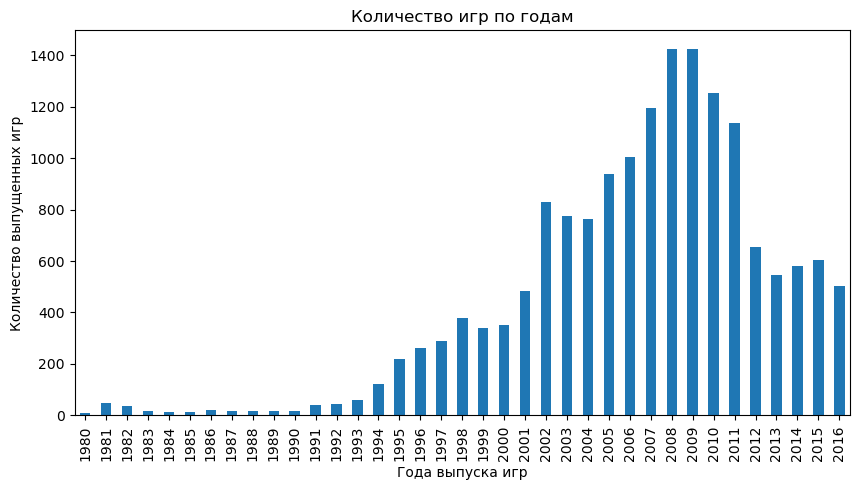

In [37]:
# Посмотрим на количество выпущенных игр по годам.
data.groupby('year_of_release')['name'].count().plot(kind='bar',\
                                                     xlabel = 'Года выпуска игр',\
                                                     ylabel = 'Количество выпущенных игр',\
                                                     figsize = (10,5),\
                                                     title = 'Количество игр по годам');

Пик выпуска игр пришелся на 2008-2009 годы. Так как рынок компьютерных игр очень динамичен, то для нашего исследования весь представленный период интереса не представляет. В дальнейшем мы будем рассматривать последние несколько лет.

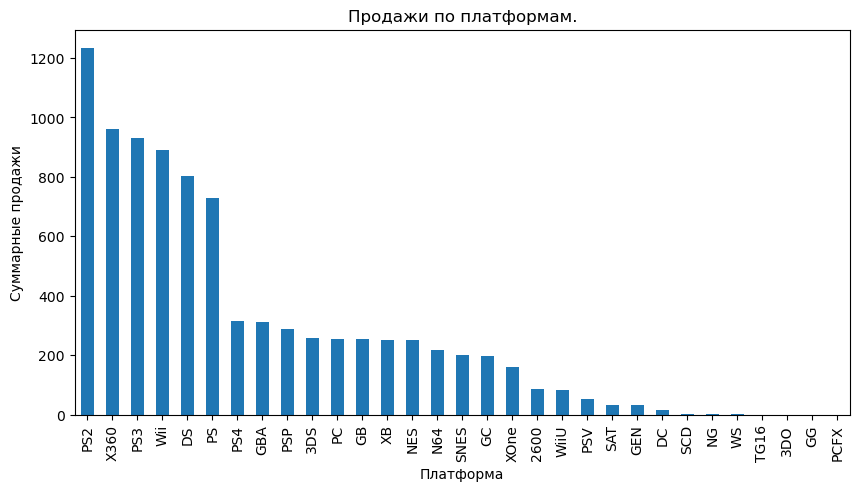

In [38]:
# Посмотрим на суммарные продажи игр по платформам.
best_platform = data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
best_platform.plot(kind='bar',\
                   figsize=(10,5),\
                   xlabel='Платформа',\
                   ylabel='Суммарные продажи',\
                   title='Продажи по платформам.');

In [39]:
# Создадим список платформ с наибольшими суммарными продажами.
best_platform_list = list(best_platform.head(6).index)
best_platform_list

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

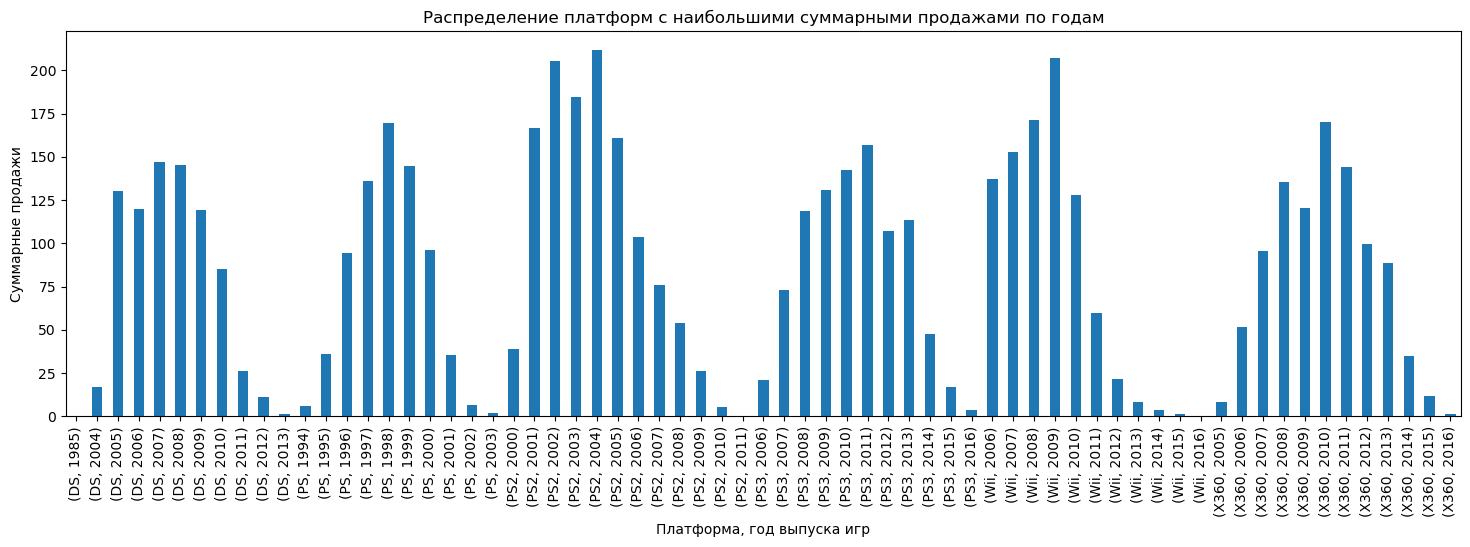

In [40]:
# Строим распределение платформ с наибольшими суммарными продажами по годам.
data.query('platform in @best_platform_list')\
    .groupby(['platform', 'year_of_release'])['total_sales'].sum()\
    .plot(kind='bar',
          figsize = (18,5),\
          xlabel = 'Платформа, год выпуска игр',\
          ylabel='Суммарные продажи',\
          title='Распределение платформ с наибольшими суммарными продажами по годам');

Из графика можно увидеть, что с момента появления новой платформы до момента прекращения продаж на ней проходит от 10 до 12 лет. А пик продаж проходится в среднем на 4-5 годы существования платформы. 

### 2.2 Выберем несколько потенциально прибыльных платформ.

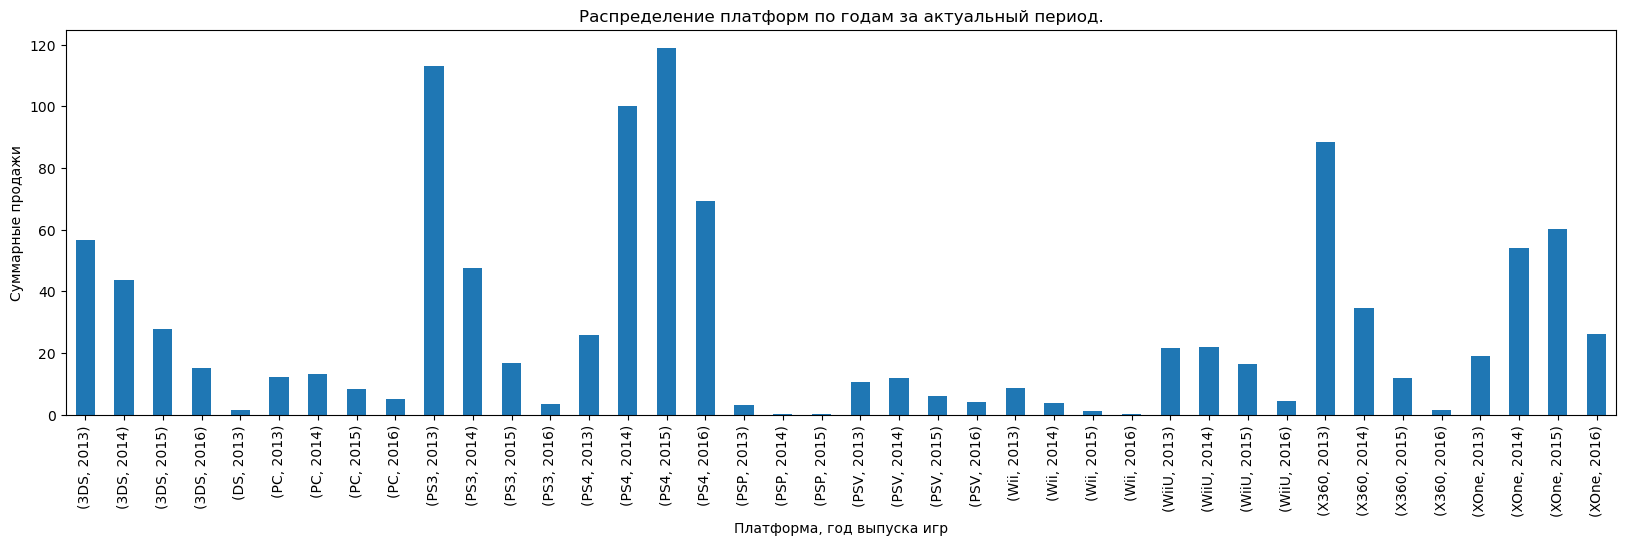

In [41]:
# Данные за актуальный период (с 2013года).
data.query('year_of_release >= 2013')\
    .groupby(['platform', 'year_of_release'])['total_sales'].sum()\
    .plot(kind='bar',\
          figsize = (20,5),\
          xlabel = 'Платформа, год выпуска игр',\
          ylabel='Суммарные продажи',\
          title='Распределение платформ по годам за актуальный период.');

На графике видно, что в период с 2013 по 2016 годы по продажам лидируют такие платформы как PS3, PS4, X360. Однако на PS3 и X360 продажи в 2016 году уже сильно упали и вероятно в 2017 году они сойдут на нет. К потенциально прибыльным платформам можно отнести ещё 3DS и XOne. Лидером же является платформа PS4, её продажи в 2016 году в районе 70 млн.

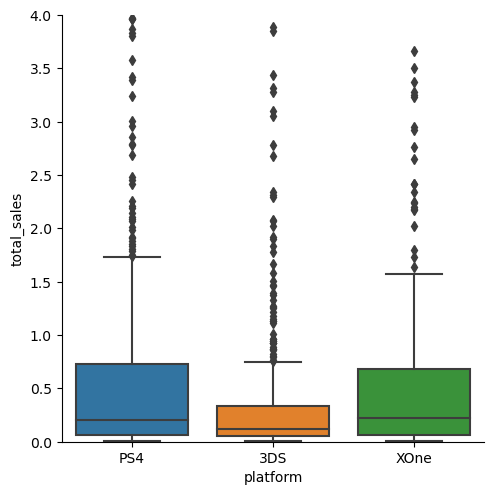

In [42]:
# График ящик с усами по глобальным продажам в разбивке по платфармам.
sns.catplot(data=data.query('platform == "3DS" or platform == "XOne" or platform == "PS4"'),\
            x='platform', y='total_sales', kind='box')
plt.ylim(0,4);


In [43]:
data.query('platform == "3DS" or platform == "XOne" or platform == "PS4"')\
    .groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,512.0,0.503535,1.441271,0.01,0.05,0.12,0.3325,14.60
PS4,392.0,0.801378,1.609456,0.01,0.06,0.20,0.7300,14.63
XOne,247.0,0.645020,1.036139,0.01,0.06,0.22,0.6850,7.39


In [44]:
# Посмотрим на суммарные продажи по выбранным платформам.
data.query('platform == "3DS" or platform == "XOne" or platform == "PS4"')\
    .groupby('platform')['total_sales'].sum()

platform
3DS     257.81
PS4     314.14
XOne    159.32
Name: total_sales, dtype: float64

Нижний квартиль на всех трёх платформах проходит примерно на одном уровне 0,05 - 0,06. 
Медиана на платформе 3DS ниже, чем на двух других на 0,1 млн.копий. 
Верхние квартили на платформах XOne и PS4 выше более, чем в 2 раза. Также на графиках (XOne,PS4) усы заметно длинее. Это говорит о том, что на этих платформах игры чаще продаются большим числом копий.Здесь также видно, что лидером является платформа PS4, все её показатели выше и суммарные продажи почти в 2 раза больше, чем на платформе XOne.


### 2.3 Посмотрим как влияют отзывы пользователей и критиков на продажи.

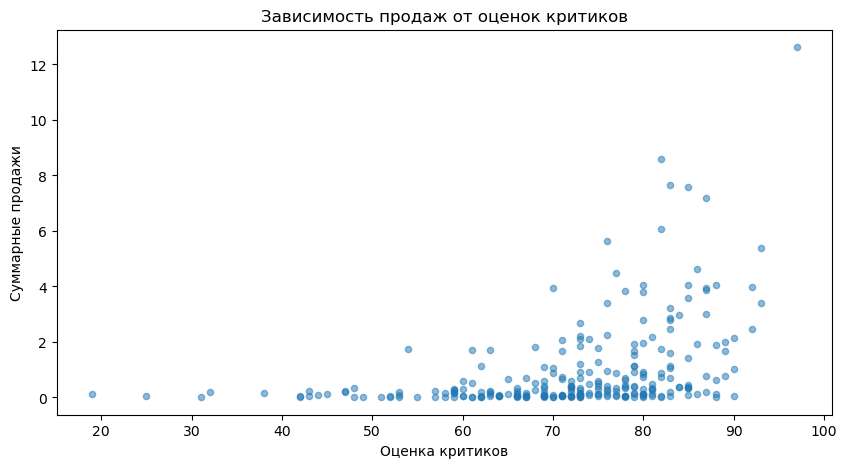

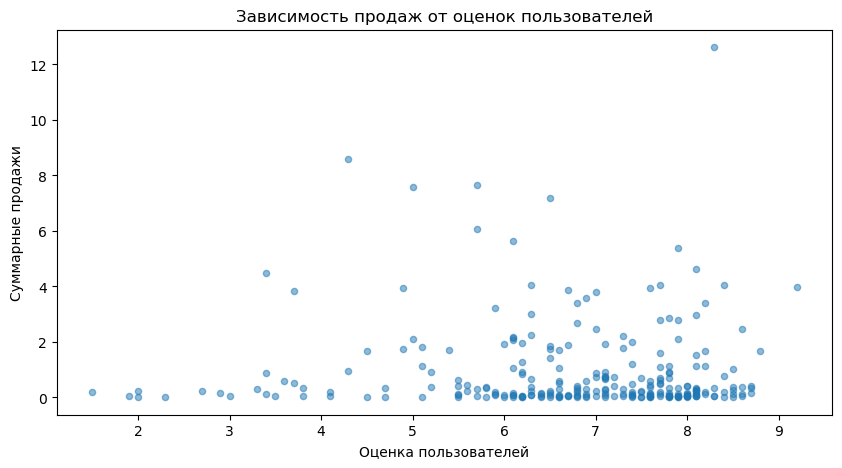

In [46]:
# Построим диагаммы рассеиния.
ps4_scores = data.loc[data['platform'] == 'PS4']

ps4_scores.plot(x='critic_score',\
                y='total_sales',\
                kind='scatter',\
                figsize=(10,5),\
                xlabel='Оценка критиков',\
                ylabel='Суммарные продажи',\
                title='Зависимость продаж от оценок критиков',\
                alpha=0.5),
ps4_scores.plot(x='user_score',\
                y='total_sales',\
                kind='scatter',\
                figsize=(10,5),\
                xlabel='Оценка пользователей',\
                ylabel='Суммарные продажи',\
                title='Зависимость продаж от оценок пользователей',\
                alpha=0.5);

In [47]:
# Подсчет корреляции между отзывами и продажами.
ps4_scores['total_sales'].corr(ps4_scores['critic_score']),\
ps4_scores['total_sales'].corr(ps4_scores['user_score'])

(0.40656790206178145, -0.03195711020455645)

На первом графике заметно и корреляция это подтверждает, что есть зависимость между продажами и оценками критиков, но небольшая. Зависимости же продаж от оценок пользователей нет.

In [311]:
# Посмотрим влияние отзывов пользователей и критиков на продажи на платформе 3DS.
platform_3ds[['critic_score', 'user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.745222,0.348740
user_score,0.745222,1.000000,0.222078
total_sales,0.348740,0.222078,1.000000


In [312]:
# Посмотрим влияние отзывов пользователей и критиков на продажи на платформе XOne.
platform_xone[['critic_score', 'user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.472462,0.416998
user_score,0.472462,1.000000,-0.068925
total_sales,0.416998,-0.068925,1.000000


Значения коэффициента корреляции на платформах XOne и PS4 практически одинаковые. На 3ds корреляция по оценкам пользователей положительная и составляет 0,22. Однако это слабая корреляция и мы не можем сказать, что оценкb пользователей оказывают большое влияние на продажи.

### 2.4 Посмотрим какие жанры пользуются большим спросом.

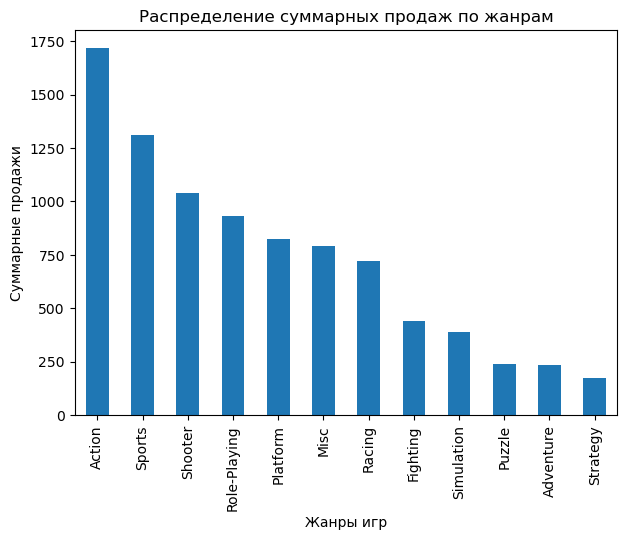

In [48]:
# Распределение продаж по жанрам. 
data.groupby('genre')['total_sales'].sum()\
    .sort_values(ascending=False).plot(kind='bar',\
                                       figsize=(7,5),\
                                       xlabel='Жанры игр',\
                                       ylabel='Суммарные продажи',\
                                       title='Распределение суммарных продаж по жанрам');

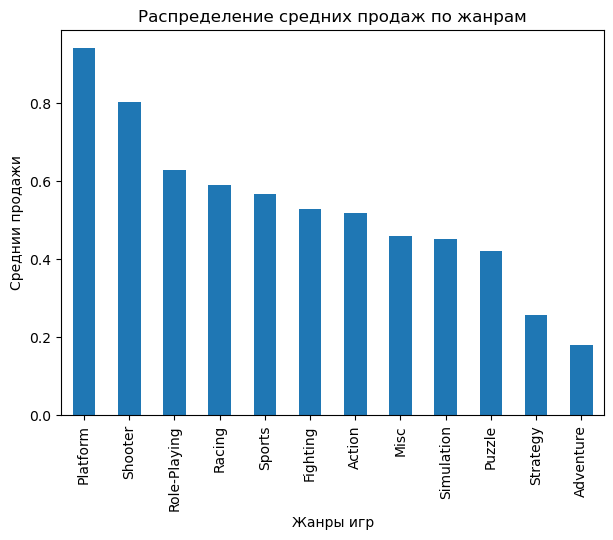

In [49]:
# Распределение средних продаж по жанрам.
data.groupby('genre')['total_sales'].mean()\
    .sort_values(ascending=False).plot(kind='bar',\
                                       figsize=(7,5),\
                                       xlabel='Жанры игр',\
                                       ylabel='Среднии продажи',\
                                       title='Распределение средних продаж по жанрам');

Самые большие продажи у игр с жанрами Action и Sports, а наименьшие продажи в таких жанрах как Puzzle, Adventure и Strategy.
Если смотреть на средние продажи, то на первое место выходят такие жанры как Platform и Shooter. на последнем также остаются Adventure и Strategy.

## 3. Портрет пользователя каждого региона.

### 3.1 Посмотрим на топ-5 популярных платформ в каждом регионе.

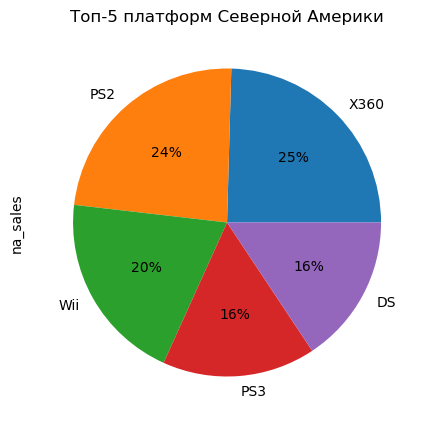

In [53]:
# Самые популярные платформы (топ-5) для пользователей из северной америки.
data.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5).plot(kind='pie',\
                                                                                     autopct='%1.0f%%',\
                                                                                     figsize=(5,5),\
                                                                                     title='Топ-5 платформ Северной Америки');

Среди пяти самых популярных платформ в Северной Америке почти половина продаж приходится на две платформы PS2 и X360. Оставшуюся половину делят между собой такие платформы как Wii, PS3, DS. 

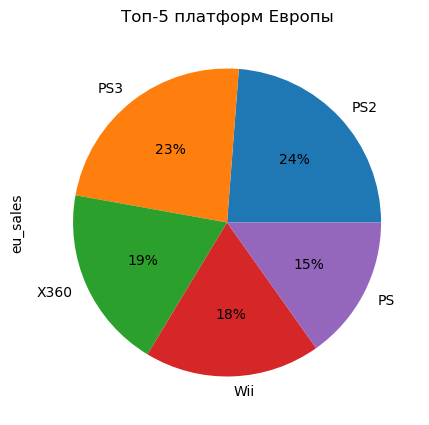

In [40]:
# Самые популярные платформы (топ-5) для пользователей из европы.
data.groupby('platform')['eu_sales'].sum()\
.sort_values(ascending=False).head(5).plot(kind='pie',\
                                           autopct='%1.0f%%',\
                                           figsize=(5,5),\
                                           title='Топ-5 платформ Европы');

У пользователей из Европы в пятёрку популярных платформ попали те же, что и в Северной америке, с одним только отличием - в Европе более популярна консоль PS, в то время как в Америке DS. Также отличается и распределение продаж по платформам. Половину из них делят между собой PS2 и PS3, продажы на X360 в Европе ниже и составляют 19%.

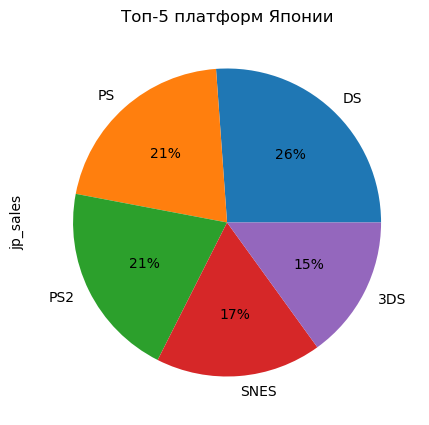

In [39]:
# Самые популярные платформы (топ-5) для пользователей из японии.
data.groupby('platform')['jp_sales'].sum()\
    .sort_values(ascending=False).head(5).plot(kind='pie',\
                                               autopct='%1.0f%%',\
                                               figsize=(5,5),\
                                               title='Топ-5 платформ Японии'); 

В Японии же самая популярная платформа DS, на неё приходится более 26 продаж. По 21% имеют платформы PS и PS2.

### 3.2 Посмотрим на топ-5 популярных жанров по каждому региону.

In [318]:
# Самые популярные жанры (топ-5) для пользователей из северной америки.
data.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)  

genre
Action      863.17
Sports      671.20
Shooter     584.83
Platform    444.44
Misc        399.57
Name: na_sales, dtype: float64

In [319]:
# Самые популярные жанры (топ-5) для пользователей из европы.
data.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5) 

genre
Action     510.99
Sports     371.33
Shooter    314.52
Racing     234.49
Misc       210.60
Name: eu_sales, dtype: float64

Здесь наблюдается схожесть интересов у пользователей из Америки и Европы. И те и другие больше всего предпочитают игры в жанрах Action, Sports, Shooter 

In [320]:
# Самые популярные жанры (топ-5) для пользователей из японии.
data.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

genre
Role-Playing    353.39
Action          160.14
Sports          134.93
Platform        130.71
Misc            107.02
Name: jp_sales, dtype: float64

В Японии же на первое место с отрывом более, чем в 2 раза выходят игры в жанре Role-Playing.

### 3.3 Посмотрим влияет ли рейтинг ESRB на продажи в регионах.

ESRB (Entertainment Software Rating Board) - ассоциация, определяющая возрастной рейтинг компьютерных игр.

Рейтинги от организации ESRB:
Все (E)
Подросток (Т)
Зрелые 17+ (М)
Все 10+ (E10+)
Раннее детство (ЕС)
Раннее детство (K-A)
Рейтинг в ожидании (RP)
Только для взрослых 18+ (АО)

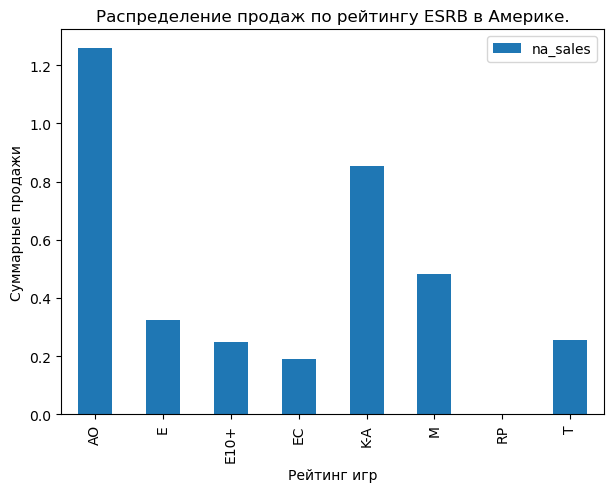

In [50]:
# Распределение продаж по рейтингу ESRB в Америке.
data.pivot_table(index='rating', values='na_sales').plot(y='na_sales',\
                                                         kind='bar',\
                                                         figsize=(7,5),\
                                                         xlabel='Рейтинг ESRB',\
                                                         ylabel='Суммарные продажи',\
                                                         title='Распределение продаж по рейтингу ESRB в Америке.');

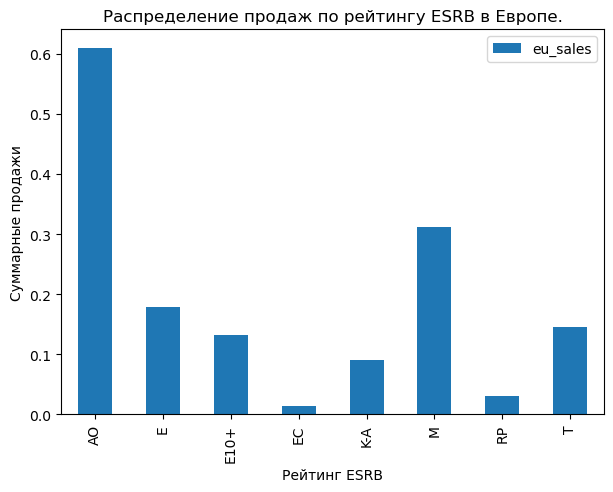

In [55]:
# Распределение продаж по рейтингу ESRB в Европе.
data.pivot_table(index='rating', values='eu_sales').plot(y='eu_sales',\
                                                         kind='bar',\
                                                         figsize=(7,5),\
                                                         xlabel='Рейтинг ESRB',\
                                                         ylabel='Суммарные продажи',\
                                                         title='Распределение продаж по рейтингу ESRB в Европе.');

Здесь опять наблюдается схожесть интересов у пользователей из Америки и Европы. И те и другие предпочитают игры для взрослых. Также в Америке пользуются спросом игры для детей раннего возраста.

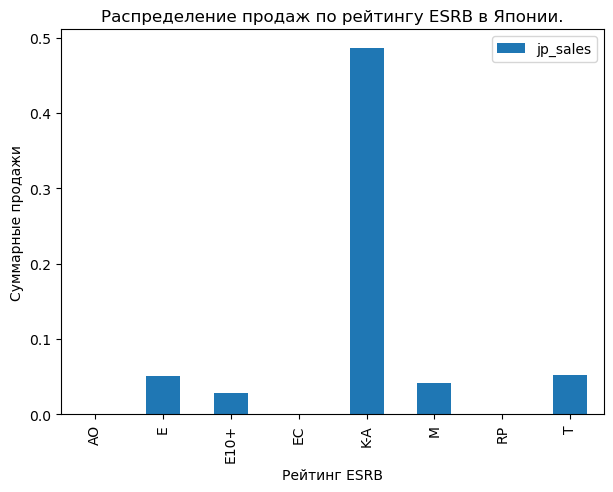

In [54]:
# Распределение продаж по рейтингу ESRB в Японии.
data.pivot_table(index='rating', values='jp_sales').plot(y='jp_sales',\
                                                         kind='bar',\
                                                         figsize=(7,5),\
                                                         xlabel='Рейтинг ESRB',\
                                                         ylabel='Суммарные продажи',\
                                                         title='Распределение продаж по рейтингу ESRB в Японии.');

В Японии же основной спрос на игры для маленьких детей. И совершенно отсутствует интерес к играм 18+.

##  4. Проверка гипотез

In [324]:
# Удалим пропуски из столбца ['user_score']
data = data.dropna(subset=['user_score'])
data['user_score'].isna().sum()

0

Ниже будем проверять две гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. Для этого будем использовать метод scipy.stats.ttest_ind.

Проверка гипотезы: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. 
```
H_0: Пользовательские рейтинги платформы Xbox One = пользовательские рейтинги платформы PC.`
H_a: Пользовательские рейтинги платформы Xbox One ≠ пользовательские рейтинги платформы PC.`
alpha = 0.05
```

In [325]:
xbox_one = data.loc[data['platform'] == 'XOne', 'user_score']
pc = data.loc[data['platform'] == 'PC', 'user_score']

results = st.ttest_ind(xbox_one, pc, equal_var=False) # вызов метода для проверки гипотезы
alpha = 0.05 # значение уровня значимости

print('p-значение:', results.pvalue) # вывод значения p-value на экран

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") # условный оператор с выводом строки с ответом

p-значение: 4.5385802963771835e-06
Отвергаем нулевую гипотезу


Проверка гипотезы: Средние пользовательские рейтинги жанров Action и Sports разные.

```
H_0: Пользовательские рейтинги платформ жанра Action = пользовательские рейтинги жанра Sports.`
H_a: Пользовательские рейтинги платформ жанра Action ≠ пользовательские рейтинги жанра Sports.`
alpha = 0.05
```


In [326]:
action = data.loc[data['genre'] == 'Action', 'user_score']
sports = data.loc[data['genre'] == 'Sports', 'user_score']

results = st.ttest_ind(action, sports, equal_var=False) # вызов метода для проверки гипотезы
alpha = 0.05 # значение уровня значимости

print('p-значение:', results.pvalue) # вывод значения p-value на экран

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") # условный оператор с выводом строки с ответом

p-значение: 0.07370217419278526
Не получилось отвергнуть нулевую гипотезу


**Общие выводы:**

* В период с 2013 по 2016 годы по продажам лидируют такие платформы как PS3, PS4, X360. Однако на PS3 и X360 продажи в 2016 году уже сильно упали и вероятно в 2017 году они сойдут на нет. К потенциально прибыльным платформам можно отнести ещё 3DS и XOne. Лидером же является платформа PS4, её продажи в 2016 году в районе 70 млн.

* Нижний квартиль на всех трёх платформах проходит примерно на одном уровне 0,05 - 0,06. Медиана на платформе 3DS ниже, чем на двух других на 0,1 млн.копий. Верхние квартили на платформах XOne и PS4 выше более, чем в 2 раза. Также на графиках (XOne,PS4) усы заметно длинее. Это говорит о том, что на этих платформах игры чаще продаются большим числом копий.Здесь также видно, что лидером является платформа PS4, все её показатели выше и суммарные продажи почти в 2 раза больше, чем на платформе XOne.

* Зависимость между продажами и оценками критиков есть, но небольшая. Зависимости же продаж от оценок пользователей нет.Значения коэффициента корреляции на платформах XOne и PS4 практически одинаковые. На 3ds корреляция по оценкам пользователей положительная и составляет 0,22. Однако это слабая корреляция и мы не можем сказать, что оценки пользователей оказывают большое влияние на продажи.

* Самые большие продажи у игр с жанрами Action и Sports, а наименьшие продажи в таких жанрах как Puzzle, Adventure и Strategy. Если смотреть на средние продажи, то на первое место выходят такие жанры как Platform и Shooter. на последнем также остаются Adventure и Strategy.

*Портрет пользователя каждого региона:*
- Среди пяти самых популярных платформ в Северной Америке почти половина продаж приходится на две платформы PS2 и X360. Оставшуюся половину делят между собой такие платформы как Wii, PS3, DS.
  У пользователей из Европы в пятёрку популярных платформ попали те же, что и в Северной америке, с одним только отличием - в Европе более популярна консоль PS, в то время как в Америке DS. Также отличается и распределение продаж по платформам. Половину из них делят между собой PS2 и PS3, продажы на X360 в Европе ниже и составляют 19%.
  В Японии же самая популярная платформа DS, на неё приходится более 26 продаж. По 21% имеют платформы PS и PS2. 
  
- Что касается жанров, то наблюдается схожесть интересов у пользователей из Америки и Европы. И те и другие больше всего предпочитают игры в жанрах Action, Sports, Shooter
  В Японии же на первое место с отрывом более, чем в 2 раза выходят игры в жанре Role-Playing.
  
- По рейтингу ESRB опять наблюдается схожесть интересов у пользователей из Америки и Европы. И те и другие предпочитают игры для взрослых. Также в Америке пользуются спросом игры для детей раннего возраста.
  В Японии же основной спрос на игры для маленьких детей. И совершенно отсутствует интерес к играм 18+.
